In [82]:
from math import ceil
from qiskit import QuantumCircuit, Aer
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import QFT
import numpy as np
import math
from fractions import Fraction

# Grover search algorithm

In [83]:
def prepareGroverBlackBox(qubits: int, markedNumber: int):
    blackBox = QuantumCircuit(qubits, name="Grover's Black Box")
    if 2**(qubits-1)-1 < markedNumber:
        raise Exception('markedNumber is too Big')
    matrix = np.zeros((2**qubits, 2**qubits))
    for i in range(2**(qubits-1)):
        binaryNumber = bin(i)[2:].rjust(qubits-1, '0')
        if i == markedNumber:
            matrix[int(binaryNumber+'0', 2)][int(binaryNumber+'1', 2)] = 1
            matrix[int(binaryNumber+'1', 2)][int(binaryNumber+'0', 2)] = 1
        else:
            matrix[int(binaryNumber+'0', 2)][int(binaryNumber+'0', 2)] = 1
            matrix[int(binaryNumber+'1', 2)][int(binaryNumber+'1', 2)] = 1
    blackBox.unitary(matrix, range(qubits))
    return Operator(blackBox).to_instruction()

def inversionAboutMean(qubits: int):
    matrix = 2*np.full((2**qubits, 2**qubits), 1/(2**qubits)) - np.eye(2**qubits)
    inversionAboutMean = QuantumCircuit(qubits, name="Inversion About Mean")
    inversionAboutMean.unitary(matrix, range(qubits))
    return Operator(inversionAboutMean).to_instruction()
    
def grover(qubits: int, markedNumber:int):
    qc = QuantumCircuit(qubits+1, qubits)
    qc.x(qubits)
    qc.barrier()
    qc.h(range(qubits+1))
    numIterations = ceil(np.sqrt(2**qubits))
    print (numIterations)
    for _ in range(numIterations):
        qc.append(prepareGroverBlackBox(qubits+1, markedNumber), range(qubits,-1,-1))
        qc.append(inversionAboutMean(qubits), range(qubits-1,-1,-1))
    qc.measure(range(qubits), range(qubits))
    return qc

4
{'0110': 33, '0010': 24, '1000': 23, '1001': 26, '1010': 34, '1110': 43, '0100': 579, '1100': 22, '1011': 35, '0001': 26, '0011': 37, '1101': 26, '1111': 31, '0111': 30, '0101': 32, '0000': 23}
0010


/Users/pijus/.pyenv/versions/3.11.4/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


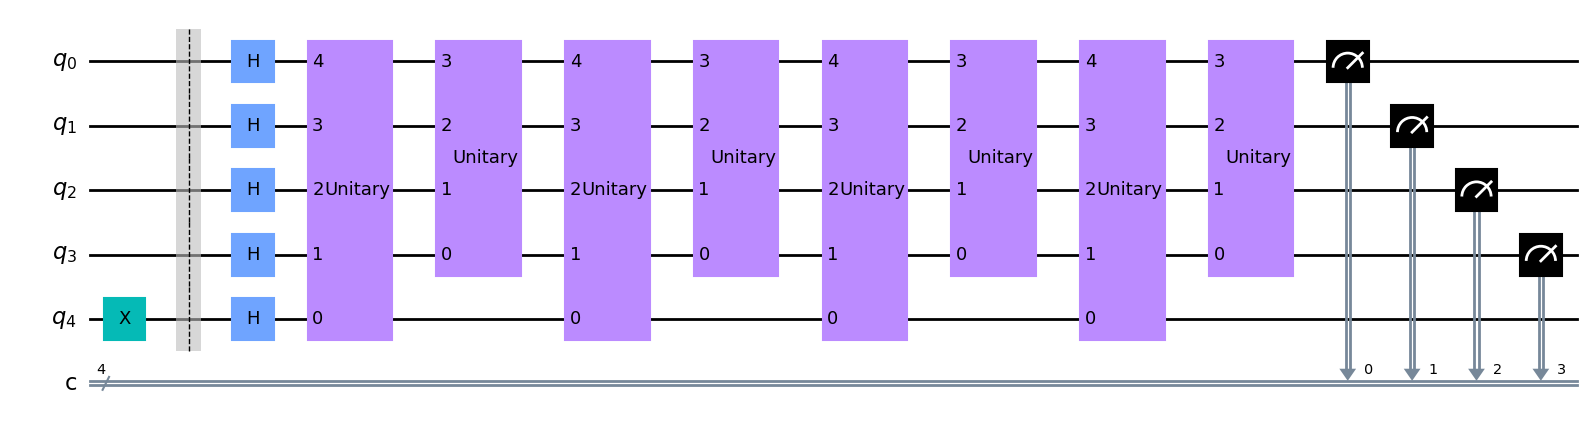

In [84]:
len = 4
number = 2

qc = grover(len, number)

backend = Aer.get_backend('qasm_simulator')
job = backend.run(qc, shots=1024)
result = job.result()
print(result.get_counts())
counts = dict(result.get_counts())
max = 0
for key, value in counts.items():
    if value > max:
        max = value
        maxKey = key

print (maxKey[::-1])
qc.draw('mpl')

# Shors factoring algorithm

In [85]:
n=4 # qft part
m=4 # modular exponentiation part

In [91]:
def aMod15(a,x,size):
    qc = QuantumCircuit(size)
    for _ in range(x):
        if a in [2,13]:
            qc.swap(0,1)
            qc.swap(1,2)
            qc.swap(2,3)
        if a in [7,8]:
            qc.swap(2,3)
            qc.swap(1,2)
            qc.swap(0,1)
        if a == 11:
            qc.swap(1,3)
            qc.swap(0,2)
        if a in [7,11,13]:
            qc.x(range(size))
    unitary = qc.to_gate()
    return unitary.control(1)

def modExp(n,m,a):
    qc = QuantumCircuit(n+m,name='modExp')
    for i in range(n):
        qc.append(aMod15(a,2**i,m),[i]+list(range(n,m+n)))
    return Operator(qc).to_instruction()

def shor(n:int, m:int, a:int=2):
    qc = QuantumCircuit(n+m, n)
    
    qc.h(range(n))
    qc.x(n+m-1)
    qc.barrier()
    qc.append(modExp(n,m,a), range(n+m))
    qc.barrier()
    qc.append(Operator(QFT(n).inverse()).to_instruction(), range(n))

    qc.measure(range(n), range(n))
    return qc

def processMeasurement(measurement,n):
    binaryString = ''.join(map(str, measurement))
    measuredInt = int(binaryString,2)
    phase = measuredInt/(2**n)
    f = Fraction.from_float(phase).limit_denominator(n)
    _,r = f.numerator, f.denominator
    print ("corresponding phase",phase," r ",r)
    return r, phase

In [101]:
N = 15 # number to factor

coprime = False
while coprime == False:
    a = np.random.randint(2, N)
    if math.gcd(a,N) == 1 and a in [2,7,8,11,13]:
        coprime = True

factorFound = False
attempts = 0
print ("trying with a=",a,"and N=",N)
while factorFound == False:
    attempts += 1
    qc = shor(n,m,a)
    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(qc, shots=1)
    result = job.result()
    counts = list(result.get_counts().keys())
    print ("attempts",attempts,"counts",counts)
    r, phase = processMeasurement(counts[0],n)
    if phase != 0:
        guesses = [math.gcd(a**(r//2)-1,N), math.gcd(a**(r//2)+1,N)]
        print ("guesses",guesses)
        for guess in guesses:
            if guess not in [1,N] and N%guess == 0:
                factorFound = True
                print ("Found non trivial factors of",N,"; ",guess,"and",N//guess)
                break

trying with a= 8 and N= 15
attempts 1 counts ['1000']
corresponding phase 0.5  r  2
guesses [1, 3]
Found non trivial factors of 15 ;  3 and 5


/Users/pijus/.pyenv/versions/3.11.4/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


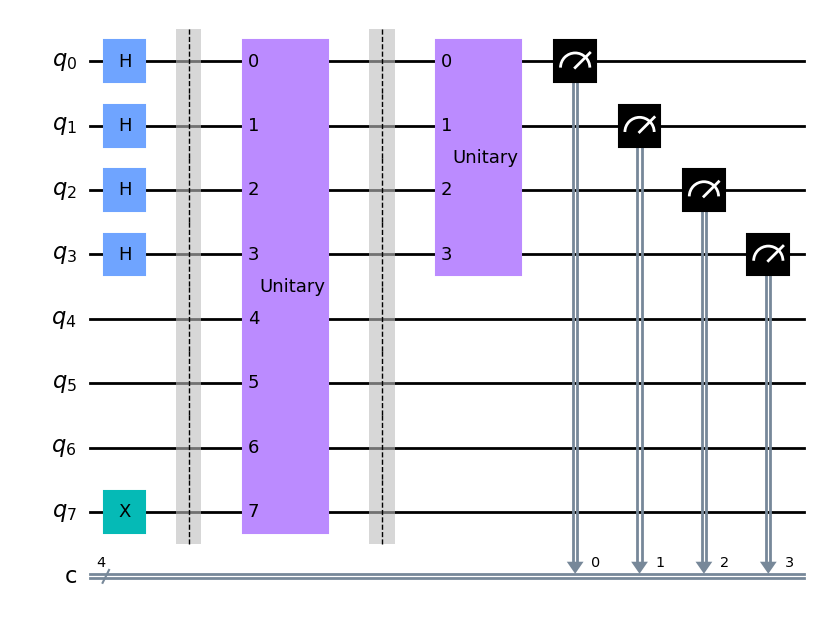

In [102]:
qc = shor(n,m)
qc.draw('mpl')